In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import norm, multivariate_normal
from scipy.optimize import minimize_scalar
from scipy import integrate, interpolate

In [24]:
# Loading in the data.
def LoadData(energy, key1, key2):
    #filename = f'/home/llr/ilc/ritzmann/work/ana_files_ECAL_QGSP_BERT_conf6_e-__GeV_5kevt_build_masked/data_nhits_wenergy_{energy}GeV.txt'
    filename = f'/home/llr/ilc/ritzmann/work/ECAL_QGSP_BERT_conf6_e-_GeV_5kevt_-42_-42_build_masked_data_shower_{energy}GeV.txt'
    df = pd.read_csv(filename, header=0)
    
    return df[[key1, key2]]

data_sum_events = pd.read_csv('/home/llr/ilc/ritzmann/work/ECAL_QGSP_BERT_conf6_e-_GeV_5kevt_-42_-42_build_masked_params_sum_events.txt', header=0)
data_sum_energy_weighted = pd.read_csv('/home/llr/ilc/ritzmann/work/ECAL_QGSP_BERT_conf6_e-_GeV_5kevt_-42_-42_build_masked_params_sum_energy_weighted.txt', header=0)
data_sum_energy_weighted_masking = pd.read_csv('/home/llr/ilc/ritzmann/work/ECAL_QGSP_BERT_conf6_e-_GeV_5kevt_-42_-42_build_masked_params_sum_energy_weighted_masking.txt', header=0)

In [39]:
#calculate the means, and the covariance matrices for all the different energies
Energies = [0.25, 0.5, 0.7, 1, 2, 5, 8, 10, 20, 40, 60, 80, 100, 150, 200, 250]

means1 = []
means2 = []
sigmas1 = []
sigmas2 = []
rhos = []

for energy in Energies:
    df = LoadData(energy, 'wnhits', 'wenergy2')
    mean = np.mean(df.to_numpy(), axis=0)
    cov = np.cov(df.to_numpy(), rowvar=0)
    sigma1 = np.sqrt(cov[0][0])
    sigma2 = np.sqrt(cov[1][1])
    #rho_new = cov[1][0]
    rho = cov[1][0]/(sigma1*sigma2)
    means1.append(mean[0])
    means2.append(mean[1])
    sigmas1.append(sigma1)
    sigmas2.append(sigma2)
    rhos.append(rho)
    
df1 = pd.DataFrame({
    
    'energy': Energies,
    'mean_nhit':means1,
    'mean_sumE':means2,
    'sigma_nhit':sigmas1,
    'sigma_sumE':sigmas2,
    'rhoNew':rhos
})
df1

,energy,mean_nhit,mean_sumE,sigma_nhit,sigma_sumE,rhoNew
0,0.25,10.196140,17.924750,3.292144,9.346572,0.624539
1,0.50,19.051486,37.116136,4.571822,13.099297,0.603306
2,0.70,25.312691,52.737610,5.315432,15.730817,0.598834
3,1.00,34.422654,75.602033,6.326158,19.038108,0.574832
4,2.00,61.180430,156.878458,8.643864,27.101295,0.559168
5,5.00,127.262456,402.632936,12.851437,44.640552,0.543496
6,8.00,183.122207,654.971861,15.541047,58.065189,0.523541
7,10.00,217.464612,824.301761,16.615693,64.852085,0.497481
8,20.00,363.207064,1681.935758,22.468156,95.803691,0.472379
9,40.00,591.727492,3416.270156,30.899720,141.990260,0.450485


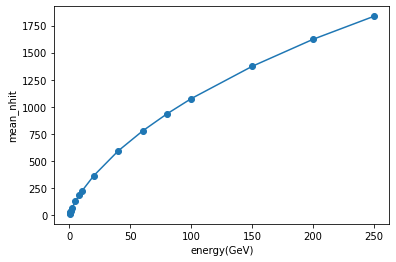

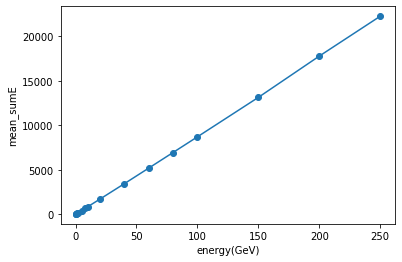

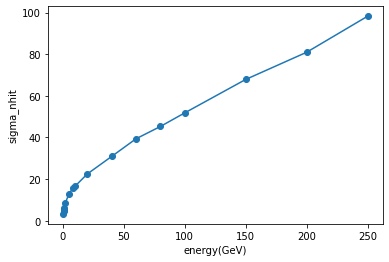

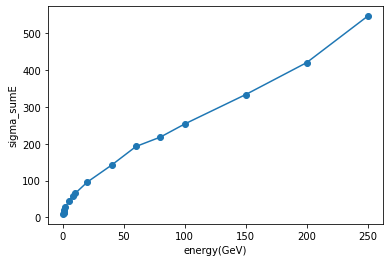

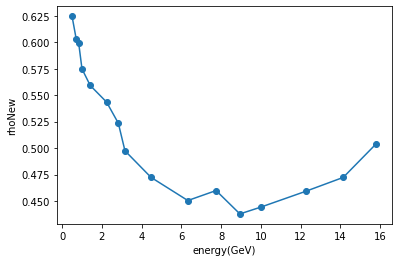

In [40]:
# drawing linearity plots for each of them
#df2 = df1
#Nmax=len(df2)
#df1 = df2[:Nmax]
plt.figure()
#plt.plot(1/np.sqrt(df1['energy']), df1['mean_nhit'], 'o-')
plt.plot(df1['energy'], df1['mean_nhit'], 'o-')
#plt.ylim(0, df2['energy'][Nmax-1]+1)
plt.ylabel('mean_nhit')
plt.xlabel('energy(GeV)')
plt.show()
plt.figure()
#plt.plot(1/np.sqrt(df1['energy']), df1['mean_sumE'], 'o-')
plt.plot(df1['energy'], df1['mean_sumE'], 'o-')
plt.ylabel('mean_sumE')
plt.xlabel('energy(GeV)')
#plt.ylim(0, df2['energy'][Nmax-1]+1)
plt.show()
plt.figure()
#plt.plot(1/np.sqrt(df1['energy']), df1['sigma_nhit'], 'o-')
plt.plot(df1['energy'], df1['sigma_nhit'], 'o-')
plt.ylabel('sigma_nhit')
plt.xlabel('energy(GeV)')
#plt.ylim(0, df2['energy'][Nmax-1]+1)
plt.show()
plt.figure()
#plt.plot(1/np.sqrt(df1['energy']), df1['sigma_sumE'], 'o-')
plt.plot(df1['energy'], df1['sigma_sumE'], 'o-')
plt.ylabel('sigma_sumE')
plt.xlabel('energy(GeV)')
#plt.ylim(0, df2['energy'][Nmax-1]+1)
plt.show()

plt.figure()
#plt.plot(1/np.sqrt(df1['energy']), df1['rhoNew'], 'o-')
plt.plot(np.sqrt(df1['energy']), df1['rhoNew'], 'o-')
plt.ylabel('rhoNew')
plt.xlabel('energy(GeV)')
#plt.ylim(0, df2['energy'][Nmax-1]+1)
plt.show()


In [41]:
def parabola(x, a, b, c, d):
    y = a*x*x*x + b*x*x + c*x + d
    return y

f_nhits_mean = interpolate.interp1d(df1['energy'], df1['mean_nhit'], kind = 'cubic', fill_value='extrapolate')
f_sumE_mean = interpolate.interp1d(df1['energy'], df1['mean_sumE'], kind = 'cubic', fill_value='extrapolate')
f_nhits_sigma = interpolate.interp1d(df1['energy'], df1['sigma_nhit'], kind = 'cubic', fill_value='extrapolate')
f_sumE_sigma = interpolate.interp1d(df1['energy'], df1['sigma_sumE'], kind = 'cubic', fill_value='extrapolate')
f_rhoNew = interpolate.interp1d(df1['energy'], df1['rhoNew'], kind = 'cubic', fill_value='extrapolate')

In [58]:
print(nhit_params, np.sqrt(np.diag(nhit_params_cov)))
print(sumE_params, np.sqrt(np.diag(sumE_params_cov)))
print(sigma_nhit_params, np.sqrt(np.diag(sigma_nhit_params_cov)))
print(sigma_sumE_params, np.sqrt(np.diag(sigma_sumE_params_cov)))
print(rhoNew_params, np.sqrt(np.diag(rhoNew_params_cov)))

[ 2.61175164e-04 -8.47439126e-02  1.31181785e+01  3.03622265e+01] [5.11826611e-05 1.15098403e-02 6.44803398e-01 6.63164411e+00]
[-7.45159951e-02  2.62547154e+01  1.58156363e+04 -6.99545371e+03] [1.29549180e-02 2.91327251e+00 1.63207126e+02 1.67854482e+03]
[ 1.43582972e-05 -4.22226679e-03  6.47459873e-01  5.85934947e+00] [4.17930838e-06 9.39833336e-04 5.26512722e-02 5.41505366e-01]
[ 1.05696313e-02 -3.53466977e+00  1.02955103e+03  3.57538944e+03] [3.98514247e-03 8.96169758e-01 5.02051546e+01 5.16347627e+02]
[ 4.42280471e-01 -2.31760427e+02  7.15879857e+03  9.10251834e+03] [1.45329951e-01 3.26814692e+01 1.83087882e+03 1.88301378e+04]


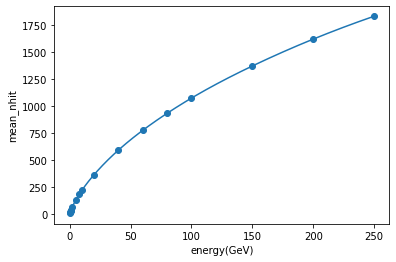

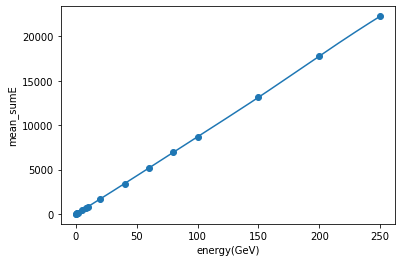

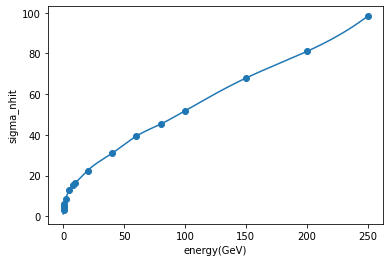

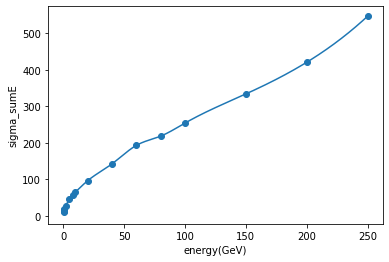

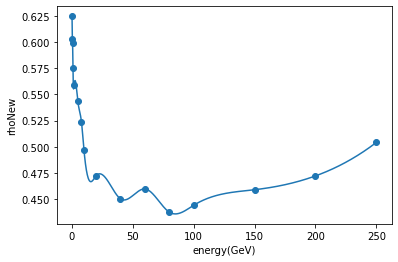

In [42]:
# drawing linearity plots for each of them
#df2 = df1
#Nmax=len(df2)
#df1 = df2[:Nmax]

plt.figure()
x = np.linspace(0, df1['energy'].max(), 1000)
plt.plot(x, f_nhits_mean(x))
plt.scatter(df1['energy'], df1['mean_nhit'])
#plt.ylim(0, df2['energy'][Nmax-1]+1)
plt.ylabel('mean_nhit')
plt.xlabel('energy(GeV)')
plt.show()

plt.figure()
x = np.linspace(0, df1['energy'].max(), 1000)
plt.plot(x, f_sumE_mean(x))
plt.scatter(df1['energy'], df1['mean_sumE'])
plt.ylabel('mean_sumE')
plt.xlabel('energy(GeV)')
#plt.ylim(0, df2['energy'][Nmax-1]+1)
plt.show()

plt.figure()
x = np.linspace(0, df1['energy'].max(), 1000)
plt.plot(x, f_nhits_sigma(x))
plt.scatter(df1['energy'], df1['sigma_nhit'])
plt.ylabel('sigma_nhit')
plt.xlabel('energy(GeV)')
#plt.ylim(0, df2['energy'][Nmax-1]+1)
plt.show()

plt.figure()
x = np.linspace(0, df1['energy'].max(), 1000)
plt.plot(x, f_sumE_sigma(x))
plt.scatter(df1['energy'], df1['sigma_sumE'], )
plt.ylabel('sigma_sumE')
plt.xlabel('energy(GeV)')
#plt.ylim(0, df2['energy'][Nmax-1]+1)
plt.show()

plt.figure()
x = np.linspace(0.25, df1['energy'].max(), 1000)
plt.plot(x, f_rhoNew(x))
plt.scatter(df1['energy'], df1['rhoNew'])
plt.ylabel('rhoNew')
plt.xlabel('energy(GeV)')
#plt.ylim(0, df2['energy'][Nmax-1]+1)
plt.show()


In [103]:
# Idea: Make a list of energies; calculate the bigaus parameters for all of them.
# Then take a random point (nhit, sum_E) and find the distribution with the greatest prob. density. that it could belong to.
energies = np.linspace(0.1, 265, 30000)

nhits = []
sumE = []
sigma_nhits = []
sigma_sumE = []
rhonew = []
for energy in energies:
    nhits_sol = f_nhits_mean(energy)
    sumE_sol = f_sumE_mean(energy)
    sigma_nhits_sol = f_nhits_sigma(energy)
    sigma_sumE_sol = f_sumE_sigma(energy)
    rhonew_sol = f_rhoNew(energy)
    nhits.append(nhits_sol)
    sumE.append(sumE_sol)
    sigma_nhits.append(sigma_nhits_sol)
    sigma_sumE.append(sigma_sumE_sol)
    rhonew.append(rhonew_sol)

In [104]:
# Create a bivariate normal distribution for each energy
normdist = []
for i in range(len(energies)):
    energy = energies[i] 
    mean = [nhits[i], sumE[i]]# this will be the mean.
    cov = np.eye(2)
    cov[0][0] = sigma_nhits[i]**2.0
    cov[1][1] = sigma_sumE[i]**2.0
    cov[1][0] = rhonew[i]*sigma_nhits[i]*sigma_sumE[i]
    cov[0][1] = rhonew[i]*sigma_nhits[i]*sigma_sumE[i]
    #cov[1][0] = rhonew[i]
    #cov[0][1] = rhonew[i]
    #print(cov)
    # cov will be the covariance matrix.
    var = multivariate_normal(mean=mean, cov=cov)
    # var will be the multivariate normal distribution.
    normdist.append(var)

In [105]:
#check if the distribution is really normalized
print(normdist[4].cdf((np.inf,np.inf)))
#print(point)
#print(mean_points)

point = np.array([[5, 60000]])
mean_points = np.array([nhits, sumE]).T
#print(mean_points)
print(np.sum((mean_points - point)**2, axis=1))

1.0
[3.59913475e+09 3.59906208e+09 3.59898899e+09 ... 1.33467069e+09
 1.33461924e+09 1.33456780e+09]


In [107]:
#def probability(x, y, normdist=normdist):
 #   point = [x, y]
  #  probs = []
   # for i in range(len(normdist)):
   #     probs.append(normdist[i].pdf(point))
    #return probs
#probability = np.vectorize(probability)

def probability(x, y, normdist = normdist):
    #1) from the list of distributions find the mean values closest to the point
    #2) calculate the pdf of this point for all distributions whose mean value lies within a radius of 3 sigmas to the point found in 1) 
    point = np.array([x , y])
    probs = []
    index = 0
    '''
    distance = np.sum((mean_points - point)**2, axis=1)
    index_closest_point = np.argmin(distance)
    #print(index_closest_point)
    if index_closest_point < 1000:
        #subset_normdist = normdist[:index_closest_point+1000]
        subset_normdist = normdist[:2000]
        index = 0
    elif index_closest_point >28999:
        #subset_normdist = normdist[index_closest_point-1000:]
        subset_normdist = normdist[-2000:]
        index = 28000
    else :
        subset_normdist = normdist[index_closest_point-1000:index_closest_point+1000]
        index = index_closest_point-1000
    #print(subset_normdist)
    for i in range(len(subset_normdist)):
        probs.append(subset_normdist[i].pdf(point))
    '''
    for i in range(len(normdist)):
        probs.append(normdist[i].pdf(point))
    return index, probs
probability=np.vectorize(probability)
        
    
for energy in Energies:
    df=df.append(LoadData(energy, 'wnhits', 'wenergy2'))
df

,wnhits,wenergy2
0,1806.32,21778.3
1,1748.10,22357.0
2,1871.24,22194.5
3,1798.36,21700.8
4,1964.85,22673.3
...,...,...
2915,1951.33,22284.4
2916,1788.39,22249.4
2917,1844.10,22776.2
2918,1869.99,22649.1


In [109]:
Energies = [0.25, 0.5, 0.7, 1, 2, 5, 8, 10, 20, 40, 60, 80, 100, 150, 200, 250]
histograms = []
histogram_values = []
binning = []
mean_values = []
std_values = []

for energy, mean_hit, mean_sumE in zip(Energies, means1, means2):
    print(f"Energy(GeV):{energy}")
    df = LoadData(energy, 'wnhits', 'wenergy2')
    hist_val = []
    for i in range(len(df)):
        point = np.array([df['wnhits'][i], df['wenergy2'][i]])
        index, prob = probability(point[0], point[1])
        hist_val.append(energies[np.argmax(prob)+index])
        print('#', end = '')
    #print(hist_val)
    histogram_values.append(hist_val)
    hist, bin_edges = np.histogram(np.array(hist_val), bins = 'auto')
    histograms.append(hist)
    binning.append(bin_edges)
    mean_values.append(np.mean(np.array(hist_val)))
    std_values.append(np.std(np.array(hist_val)))

Energy(GeV):0.25
#######################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Energy(GeV):10
################################################################################################################################

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



##################################################################################################################################################################################################################################################################################################################################################################Energy(GeV):20
#######################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



##########################################################################################################################################################################################################################################Energy(GeV):40
###############################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [110]:
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def fit_gauss(hist, bin_edges):
    n = len(hist)
    x_hist = np.zeros(n)
    y_hist = np.array(hist)
    for i in range(n):
        x_hist[i] = (bin_edges[i+1] + bin_edges[i])/2
    mean = sum(x_hist*y_hist)/sum(y_hist)                  
    sigma = sum(y_hist*(x_hist-mean)**2)/sum(y_hist) 
    print(mean, sigma)    
    param, cov = curve_fit(gauss_function, x_hist, y_hist, p0=[np.max(y_hist), mean, sigma])
    hist_x2 = np.linspace(bin_edges[0], bin_edges[-1], 300)
    plt.plot(hist_x2, gauss_function(hist_x2, param[0], param[1], param[2]))
    return param,cov

print(mean_values)
print(std_values)

[0.24160146754390813, 0.485777686911541, 0.6830648663572686, 0.9823888398150346, 1.9807854503633753, 4.97397563619522, 7.977107423954878, 9.97910680255808, 19.967128826805915, 39.95517251977871, 59.953371936045166, 79.96133599443294, 99.93979377468894, 149.9299410508072, 199.91120534164392, 249.842845121093]
[0.09033984488023487, 0.13864948865107998, 0.16988691942092465, 0.2069704001978659, 0.30042422877281877, 0.5116367639472055, 0.6606429259754398, 0.7322910100858773, 1.0918958800886753, 1.6162216057428462, 2.184995083364849, 2.455652594216624, 2.867591503956478, 3.602756668063604, 4.371907886957594, 6.068431650352547]


0.24169459264206605 0.008115200512663212
0.4855085752858429 0.019460515645868433
0.6833053547342692 0.028938738374898486
0.9827031646712875 0.04289076203727703
1.9812101096589654 0.0909398198132714
4.972836280481225 0.26385572892027326
7.977373261824157 0.4375230792592811
9.979645291249188 0.5373421820017368
19.9694811535134 1.2022142877198718
39.95518464152546 2.6269820891228988
59.95665409805577 4.866662379494058
79.95981197233962 6.070637496943107
99.9434435706975 8.318130824563115
149.94027656526424 13.03992291174643
199.91771388483815 19.26941916262267
249.8399028488735 36.89789371799892
[0.37392093 0.28541757 0.24871272 0.21068073 0.15166924 0.10286274
 0.08281735 0.07338242 0.05468467 0.04045087 0.03644491 0.0307105
 0.02869319 0.0240296  0.02186925 0.024289  ]
[0.96640587 0.97155537 0.97580695 0.98238884 0.99039273 0.99479513
 0.99713843 0.99791068 0.99835644 0.99887931 0.99922287 0.9995167
 0.99939794 0.99953294 0.99955603 0.99937138]


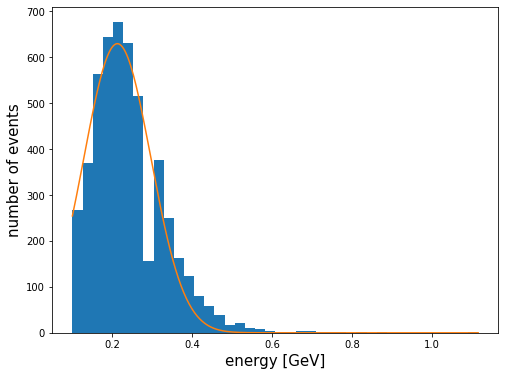

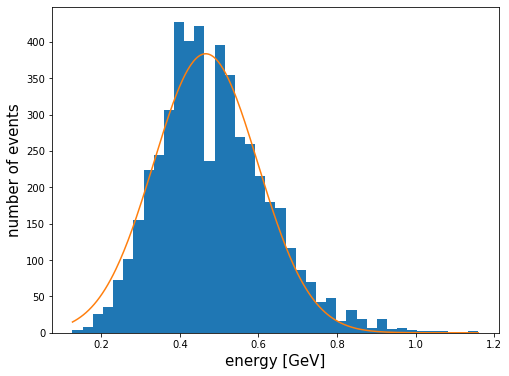

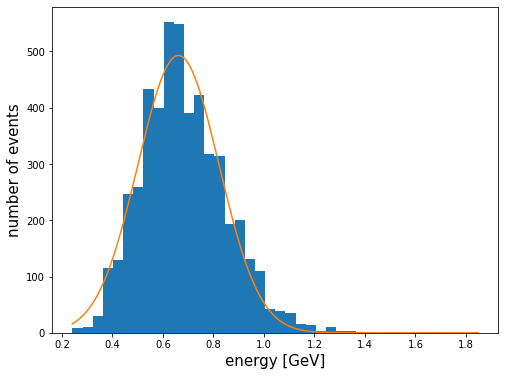

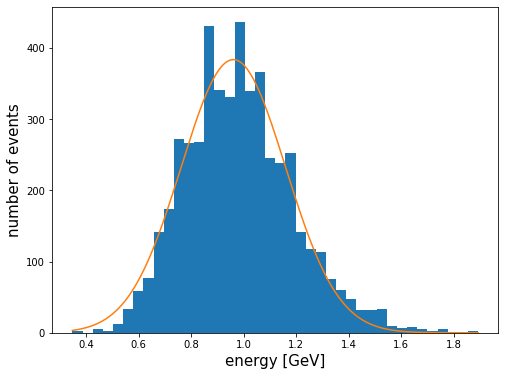

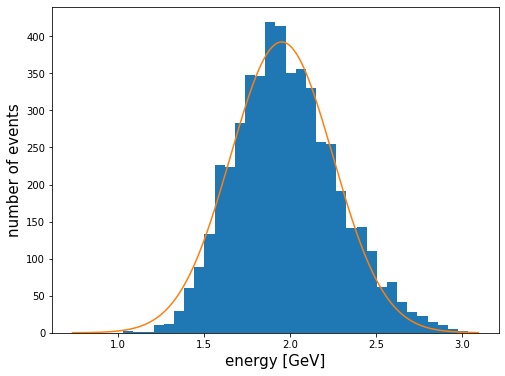

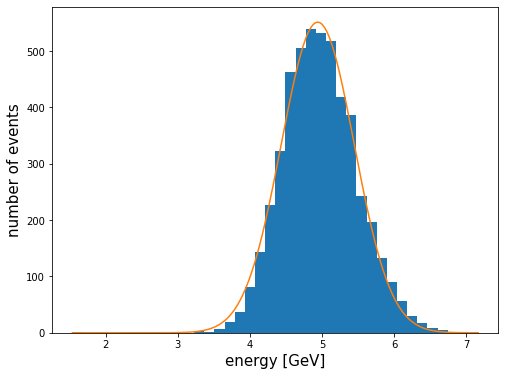

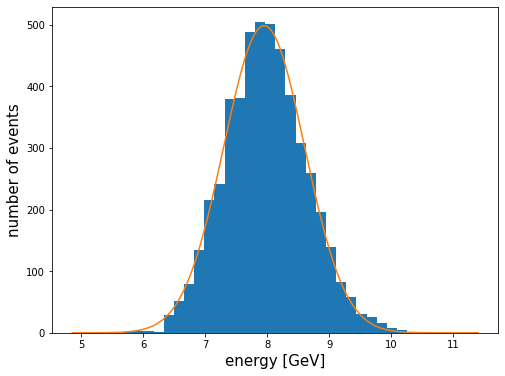

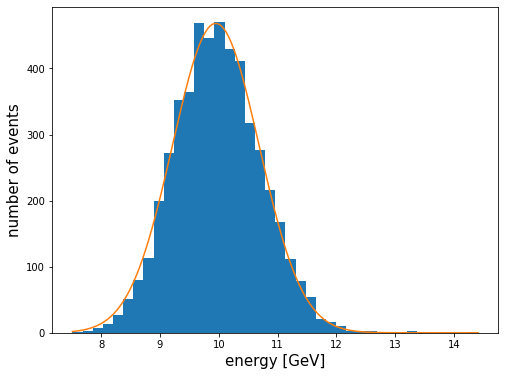

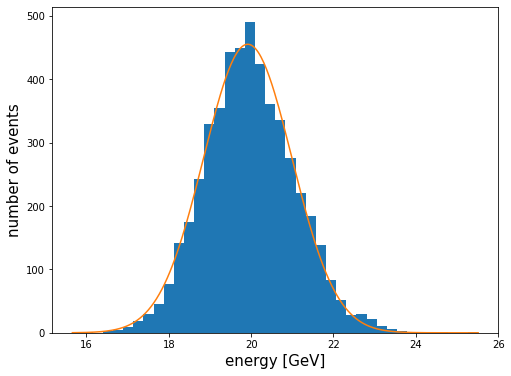

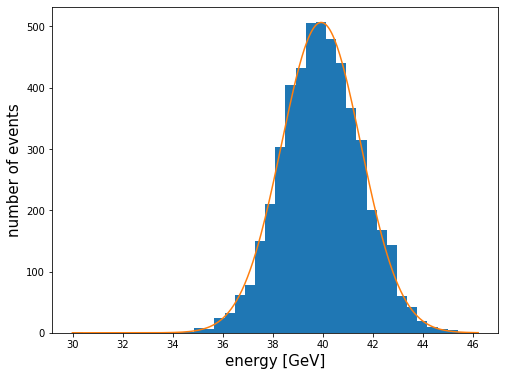

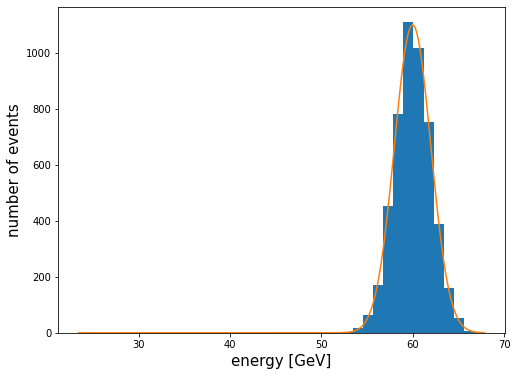

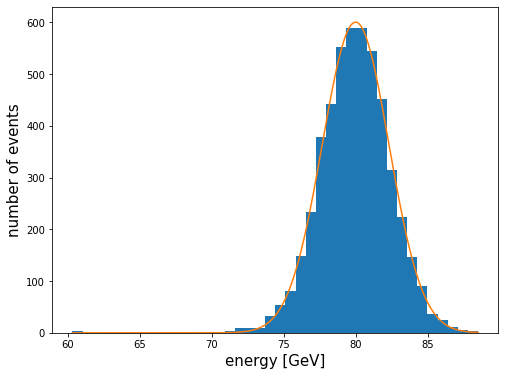

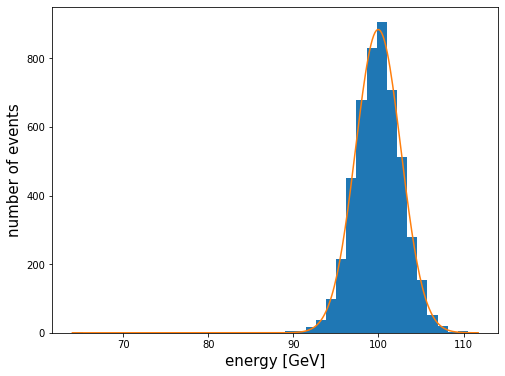

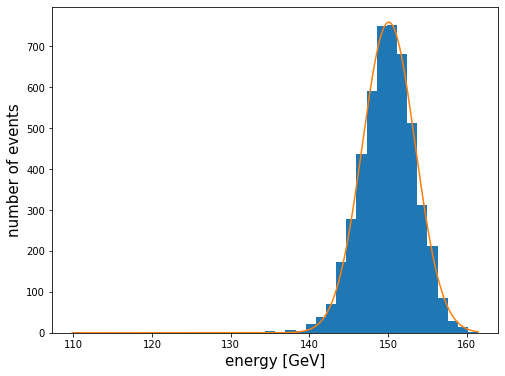

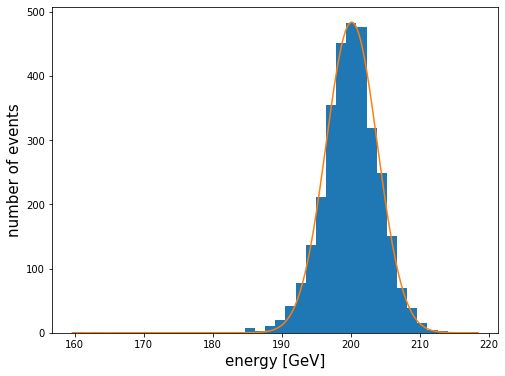

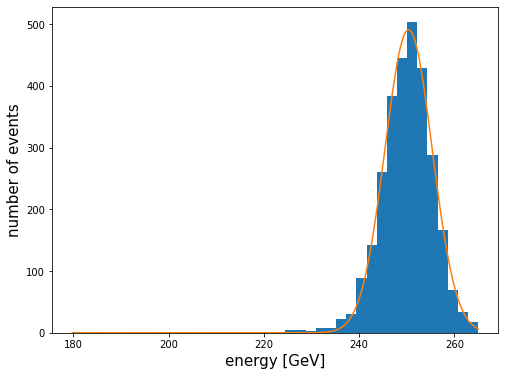

In [112]:
gauss_mean = []
gauss_sigma = []
gauss_mean_err = []

for n in range(len(Energies)):
    plt.figure(figsize=(8,6))
    histogramvals, binvals, patches = plt.hist(histogram_values[n], bins = 40)
    plt.ylabel('number of events', fontsize=15)
    plt.xlabel('energy [GeV]', fontsize=15)
    param,cov = fit_gauss(histogramvals, binvals)
    gauss_mean.append(param[1])
    gauss_sigma.append(param[2])
    gauss_mean_err.append(np.sqrt(np.diag(cov))[1])

    #plt.hist(np.array([0, 1, 2, 3, 4, 5, 5]), bins = binse)
print(np.array(std_values)/np.array(mean_values))
print(np.array(mean_values)/np.array(Energies))


In [113]:
print(gauss_mean)
print(gauss_sigma)
print(mean_values)
print(std_values)


[0.21259366355326198, 0.4656342786315913, 0.6613784039683926, 0.9601747897164145, 1.9511981624545154, 4.940333577198562, 7.951710502672478, 9.94871609061739, 19.917739782235405, 39.92640283495587, 59.98515280649829, 79.99702075980859, 99.96957653118614, 150.11402237772697, 200.11797715276103, 250.3815796087705]
[0.0836467717294321, 0.1329543620297871, 0.1604890533877527, 0.19889895300368868, 0.297902291821654, 0.5064689688719081, 0.6513302034604966, 0.7358694377851591, 1.0719362700914192, 1.5881463092727552, 1.9981503394166984, 2.3176695561818064, 2.6661010766189968, 3.3560127481393773, 3.7168648530287096, 4.963948141284052]
[0.24160146754390813, 0.485777686911541, 0.6830648663572686, 0.9823888398150346, 1.9807854503633753, 4.97397563619522, 7.977107423954878, 9.97910680255808, 19.967128826805915, 39.95517251977871, 59.953371936045166, 79.96133599443294, 99.93979377468894, 149.9299410508072, 199.91120534164392, 249.842845121093]
[0.09033984488023487, 0.13864948865107998, 0.169886919420